# **ETL TRAIN**

## CONFIGURACIÓN INICIAL

In [60]:
# descargar librerías
!pip install reverse_geocoder
!pip install seaborn
!pip install sklearn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [61]:
# importar librerías
import pandas as pd
import datetime
import reverse_geocoder as rg
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [62]:
# funcion para pasar de fecha de nacimiento a edad
def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [63]:
# leer csv
df_perf_train = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/train_performance.csv')
df_loan_test = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/test_previous_loan.csv')
df_loan_train = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/train_previous_loan.csv')
df_dem_test = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/test_datos_demograficos.csv')
df_dem_train = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/train_datos_demograficos.csv')
df_loc = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/own_data/datos_localizacion.csv')

## ANEXAR DATOS DE CLIENTES Y DE PRÉSTAMOS ANTIGUOS

In [64]:
#adjuntar los dos csv
df_dem = df_dem_test.append(df_dem_train, ignore_index=True)
#eliminar filas que sean idénticas
df_dem.drop_duplicates(inplace = True)
#dimensiones del nuevo dataframe
df_dem.shape

/var/folders/yq/lh6w6l4x3cngxbjd6ns6gxtr0000gn/T/ipykernel_17526/157330973.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dem = df_dem_test.append(df_dem_train, ignore_index=True)


(5818, 9)

In [65]:
#adjuntar los dos csv
df_loan = df_loan_test.append(df_loan_train, ignore_index=True)
#eliminar filas que sean idénticas
df_loan.drop_duplicates(inplace = True)
#dimensiones del nuevo dataframe
df_loan.shape

/var/folders/yq/lh6w6l4x3cngxbjd6ns6gxtr0000gn/T/ipykernel_17526/2168545301.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_loan = df_loan_test.append(df_loan_train, ignore_index=True)


(24090, 12)

## PREPARAR DATOS PRÉSTAMOS ANTIGUOS

In [66]:
# vista previa
df_loan.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30,2016-06-17 00:04:15.000000,NaN,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60,2017-03-02 16:22:58.000000,NaN,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30,2017-04-02 00:44:24.000000,NaN,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14.000000,2016-06-02 13:27:08.000000,10000.0,13000.0,30,2016-07-04 11:34:04.000000,NaN,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12.000000,2016-05-16 08:13:04.000000,10000.0,11500.0,15,2016-06-02 00:02:58.000000,NaN,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000


In [67]:
#pasar columnas a fecha
df_loan['firstduedate'] = pd.to_datetime(df_loan['firstduedate'])
df_loan['firstrepaiddate'] = pd.to_datetime(df_loan['firstrepaiddate'])
df_loan['firstrepaiddate'] = pd.to_datetime(df_loan['firstrepaiddate'].dt.date)

In [68]:
# guardar si se ha hecho el primer pago antes o después del plazo
df_loan['pago_plazo'] = df_loan.apply(lambda x: 1 if (x['firstduedate'] >= x['firstrepaiddate']) else -3, axis=1)

In [69]:
#nos quedamos con las columnas que importan
df_loan = df_loan[['customerid','pago_plazo']]

In [70]:
#agrupa el dataframe por cliente, obtienendo para cada uno si ha pagado en plazo o no sus prestamos
df_loan_gr = df_loan.groupby(['customerid']).sum()
df_loan_gr.head()

,pago_plazo
customerid,
8a1088a0484472eb01484669e3ce4e0b,-3
8a1a1e7e4f707f8b014f797718316cad,0
8a1a32fc49b632520149c3b8fdf85139,3
8a1eb5ba49a682300149c3c068b806c7,4
8a1edbf14734127f0147356fdb1b1eb2,2


In [71]:
# pasar la columna a binario
df_loan_gr['pagos_plazo'] = 1
df_loan_gr.loc[df_loan_gr['pago_plazo'] < 0, 'pagos_plazo'] = 0
df_loan_gr = df_loan_gr['pagos_plazo']

## ADJUNTAR TODOS LOS DATOS EN UN SOLO DATAFRAME

In [72]:
df_perf_train.shape

(4368, 10)

Añadir información de los clientes

In [73]:
# se añade la información del cliente
df_train = df_perf_train.merge(df_dem, on='customerid', how='left')
#ver tamaño del nuvo df
df_train.shape

(4368, 18)

Añadir localización de los clientes, que se obtiene de un csv diferente, el cual se ha obtenido con el proceso 1_etl_localizacion.ipynb ya que es un proceso que ha tomado 3 horas, por lo que se ha guardado los resultados en un archivo para tener que ejecutarlo una única vez.

In [74]:
# se añade la localización de los clientes
df_train = df_train.merge(df_loc, on='customerid', how='left')
#ver tamaño del nuvo df
df_train.shape

(4368, 20)

Añadir información de los préstamos antiguos de los clientes

In [75]:
# se añade la información de préstamos antiguos del cliente
df_train = df_train.merge(df_loan_gr, on='customerid', how='left')
#ver tamaño del nuvo df
df_train.shape

(4368, 21)

Añadir información de los préstamos antiguos de los referidos

In [76]:
# se añade la información de préstamos antiguos del referido del cliente
df_train = df_train.merge(df_loan_gr, left_on='referredby', right_on='customerid', how='left')
#ver tamaño del nuvo df
df_train.shape

(4368, 22)

In [77]:
df_train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,...,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,pais,estado,pagos_plazo_x,pagos_plazo_y
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,...,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,NG,Lagos,0.0,NaN
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,...,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate,NG,Oyo,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,...,11.139350,10.292041,EcoBank,NaN,Permanent,NaN,NG,Gombe,1.0,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,...,3.985770,7.491708,First Bank,NaN,Permanent,NaN,NG,Oyo,0.0,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,...,7.457913,9.076574,GT Bank,NaN,Permanent,Primary,NG,Abuja Federal Capital Territory,1.0,NaN


## TRANSFORMACIONES INICIALES EN EL DATASET

In [78]:
# quitar columnas que no se usan
# elegir las columnas
df_train_delete = ['customerid', 'systemloanid','bank_name_clients', 'bank_branch_clients', 'creationdate', 'longitude_gps', 'latitude_gps']
# borrar las columnas elegidas
df_train.drop(columns = df_train_delete, inplace = True)

In [79]:
#ver tipo de datos de las columnas
df_train.dtypes

loannumber                      int64
approveddate                   object
loanamount                    float64
totaldue                      float64
termdays                        int64
referredby                     object
good_bad_flag                  object
birthdate                      object
bank_account_type              object
employment_status_clients      object
level_of_education_clients     object
pais                           object
estado                         object
pagos_plazo_x                 float64
pagos_plazo_y                 float64
dtype: object

In [80]:
# cambiar el tipo de dato de algunas columnas
#cambiar tipo de dato
df_train['totaldue'] = df_train['totaldue'].astype('int')
df_train['pagos_plazo_x'] = df_train['pagos_plazo_x'].astype('Int64')
df_train['pagos_plazo_y'] = df_train['pagos_plazo_x'].astype('Int64')
#pasar columna a fecha
df_train['birthdate'] = pd.to_datetime(df_train['birthdate'])
df_train['approveddate'] = pd.to_datetime(df_train['approveddate'])

In [81]:
# ver registros nulos en las columnas
print(df_train.isnull().sum())

loannumber                       0
approveddate                     0
loanamount                       0
totaldue                         0
termdays                         0
referredby                    3781
good_bad_flag                    0
birthdate                        0
bank_account_type                0
employment_status_clients      657
level_of_education_clients    3763
pais                             0
estado                           1
pagos_plazo_x                    9
pagos_plazo_y                    9
dtype: int64


In [82]:
# aparecen algunos 9 registros donde los clientes no tienen datos de préstamos antiguos
# sin embargo, la columna loannumber indica lo contrario
df_train['loannumber'].min()

2

In [83]:
# al ser tan pocos registros, se opta por borrarlos
df_train.dropna(subset=['pagos_plazo_x'], inplace = True)

In [84]:
# borramos también el registro con el estado nulo
df_train.dropna(subset=['estado'], inplace = True)

In [85]:
df_train.head()

,loannumber,approveddate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,employment_status_clients,level_of_education_clients,pais,estado,pagos_plazo_x,pagos_plazo_y
0,12,2017-07-25 08:22:56,30000.0,34500,30,NaN,Good,1972-01-15,Other,Permanent,Post-Graduate,NG,Lagos,0,0
2,7,2017-07-06 14:52:57,20000.0,22250,15,NaN,Good,1984-09-18,Other,Permanent,NaN,NG,Gombe,1,1
3,3,2017-07-27 19:00:41,10000.0,11500,15,NaN,Good,1977-10-10,Savings,Permanent,NaN,NG,Oyo,0,0
4,9,2017-07-03 23:42:45,40000.0,44000,30,NaN,Good,1986-09-07,Other,Permanent,Primary,NG,Abuja Federal Capital Territory,1,1
5,8,2017-07-19 21:46:24,30000.0,39000,60,NaN,Good,1972-12-22,Savings,Permanent,NaN,NG,Lagos,1,1


## TRANSFORMACIONES EN COLUMNAS

### Histórico de pagos del cliente

- 0: El cliente tiene un mal historial de pagos
- 1: El cliente tiene un buen historial de pagos

In [86]:
df_train.rename(columns={'pagos_plazo_x': 'historial'}, inplace = True)


### Referido

- 0: El cliente ha sido referido por un cliente con un mal historial de pagos
- 1: El cliente no ha sido referido
- 2: El cliente ha sido referido por un cliente sin historial de pagos
- 3: El cliente ha sido referido por un cliente con un buen historial de pagos

In [87]:
df_train['referido'] = 0
df_train.loc[df_train['referredby'].isnull(), 'referido'] = 1
df_train.loc[(df_train['referredby'].notnull()) & (df_train['pagos_plazo_y'].isnull()), 'referido'] = 2
df_train.loc[(df_train['referredby'].notnull()) & (df_train['pagos_plazo_y'] == 1), 'referido'] = 3
# borrar columnas que ya no se usan
df_train.drop(columns = ['referredby', 'pagos_plazo_y'], inplace = True)

### Columna a predecir

In [88]:
df_train['flag'] = 0
df_train.loc[df_train['good_bad_flag'] == 'Good', 'flag'] = 1
#convertimos la columna a int
df_train['flag'] = df_train['flag'].astype('Int64')
# quitar la columna que ya no se usa
df_train.drop(columns = ['good_bad_flag'], inplace = True)

### Edad

In [89]:
# pasar de fecha de nacimiento a edad
df_train['age'] = df_train['birthdate'].apply(lambda x: from_dob_to_age(x)).astype('Int64')
# quitar la columna que ya no se usa
df_train.drop(columns = ['birthdate'], inplace = True)

### Parte del mes del pago

- 0: Final de mes
- 1: Mitad de mes
- 2: Principio de mes

In [90]:
# a partir de approveddate y termdays, se crea la columna firstduedate
df_train['firstduedate'] = df_train.apply(lambda x: x['approveddate'] + pd.DateOffset(15) if x['termdays'] == 15 else x['approveddate'] + pd.DateOffset(30), axis=1)


In [91]:
# se divide en si el dia de pago es a principio de mes, a mitad o a final
df_train.loc[df_train['firstduedate'].dt.day <= 10, 'parte_mes_pago'] = 3
df_train.loc[(df_train['firstduedate'].dt.day > 10) & (df_train['firstduedate'].dt.day <= 20), 'parte_mes_pago'] = 2
df_train.loc[df_train['firstduedate'].dt.day > 20, 'parte_mes_pago'] = 1
#cambiar tipo de dato
df_train['parte_mes_pago'] = df_train['parte_mes_pago'].astype('Int64')
# borrar columnas que ya no se usan
df_train.drop(columns = ['approveddate', 'firstduedate'], inplace = True)

### Deuda por día

In [92]:
df_train['due_per_day'] = df_train.apply(lambda x: x['totaldue'] / x['termdays'], axis=1)
df_train['due_per_day'] = df_train['due_per_day'].astype('int')

### Interés

In [93]:
df_train['interes'] = df_train.apply(lambda x: ((x['totaldue'] - x['loanamount']) / x['loanamount']) * 100, axis=1)
# borrar columnas que ya no se usan
df_train.drop(columns = ['termdays', 'totaldue', 'loanamount'], inplace = True)

### Tipo de cuenta del banco

Dummies para cada tipo

In [94]:
#ver distribución
df_train['bank_account_type'].value_counts(dropna = False)

Savings    3409
Other       885
Current      64
Name: bank_account_type, dtype: int64

In [95]:
# Inicialmente se decide hacer un label encoding, pero finalmente se usa un one hot encoding
'''
df_train['account_type'] = 0
df_train.loc[df_train['bank_account_type'] == 'Current', 'account_type'] = 1
df_train.loc[df_train['bank_account_type'] == 'Savings', 'account_type'] = 2
#borrar columnas que ya no se usa
df_train.drop(columns = ['bank_account_type'], inplace = True)
'''

"\ndf_train['account_type'] = 0\ndf_train.loc[df_train['bank_account_type'] == 'Current', 'account_type'] = 1\ndf_train.loc[df_train['bank_account_type'] == 'Savings', 'account_type'] = 2\n#borrar columnas que ya no se usa\ndf_train.drop(columns = ['bank_account_type'], inplace = True)\n"

In [96]:
# one hot encoding
df_train = pd.concat([df_train,pd.get_dummies(df_train['bank_account_type'], prefix='bank_account_type')],join='inner',axis=1)
df_train.drop(['bank_account_type'],axis=1, inplace=True)
df_train.head()

,loannumber,employment_status_clients,level_of_education_clients,pais,estado,historial,referido,flag,age,parte_mes_pago,due_per_day,interes,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings
0,12,Permanent,Post-Graduate,NG,Lagos,0,1,1,50,1,1150,15.00,0,1,0
2,7,Permanent,NaN,NG,Gombe,1,1,1,37,1,1483,11.25,0,1,0
3,3,Permanent,NaN,NG,Oyo,0,1,1,44,2,766,15.00,0,0,1
4,9,Permanent,Primary,NG,Abuja Federal Capital Territory,1,1,1,35,3,1466,10.00,0,1,0
5,8,Permanent,NaN,NG,Lagos,1,1,1,49,2,650,30.00,0,0,1


In [97]:
# Cambiar nombre de las columnas
cambios_nombre = {'bank_account_type_Current':'cuenta_corriente', 'bank_account_type_Other':'cuenta_otra', 'bank_account_type_Savings':'cuenta_ahorro'}
df_train.rename(columns = cambios_nombre, inplace = True)

### Localización

In [98]:
# vemos de que pais hay información
df_train['pais'].value_counts(dropna = False)

NG    4320
US      14
GB       4
AE       3
BJ       3
GH       3
CI       2
RU       2
CM       1
SA       1
ES       1
AU       1
TH       1
NE       1
CN       1
Name: pais, dtype: int64

Más del 99% de los datos son de Nigeria. Para estos casos, se va añadir el pib per cápita del estado de Nigeria, y para los casos fuera del país, se va a usar el pib per cápita de dicho país.

In [99]:
# leemos los csv con los pib per capita de los estados de Nigeria y de los otros países que aparecen
df_pib_nigeria = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/own_data/nigeria_pib_capita.csv')
df_pib_mundo = pd.read_csv(r'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/own_data/mundo_pib_capita.csv')

In [100]:
df_pib_nigeria.head()

,estado,pib_capita_estado
0,Abuja Federal Capital Territory,US$2317
1,Lagos,US$2174
2,Rivers,US$2396
3,Delta,US$2452
4,Oyo,US$1718


In [101]:
# transformar la columna de pib per capita de nigeria
# sacar el numero
df_pib_nigeria['pib_capita_estado'] = df_pib_nigeria['pib_capita_estado'].apply(lambda x: x[3:])
# pasar a tipo numero
df_pib_nigeria['pib_capita_estado'] = df_pib_nigeria['pib_capita_estado'].astype('int')
# pasamos de dolar a euro
df_pib_nigeria['pib_capita_estado'] = df_pib_nigeria['pib_capita_estado'] * 0.95
# redondear a euro
df_pib_nigeria['pib_capita_estado'] = df_pib_nigeria['pib_capita_estado'].astype('int')

In [102]:
df_pib_mundo.head()

,pais,pib_capita_pais
0,NG,0
1,US,63543
2,GB,40284
3,AE,43103
4,BJ,1291


In [103]:
# transformar la columna de pib per capita de los países
# pasamos de dolar a euro
df_pib_mundo['pib_capita_pais'] = df_pib_mundo['pib_capita_pais'] * 0.95
# redondear a entero
df_pib_mundo['pib_capita_pais'] = df_pib_mundo['pib_capita_pais'].astype('int')

In [104]:
# se añade el pib per capita de los otros países distintos a nigeria
df_train = df_train.merge(df_pib_mundo, on='pais', how='left')
#ver tamaño del nuvo df
df_train.shape

(4358, 16)

In [105]:
# se añade el pib per capita de los datos de Nigeria
df_train = df_train.merge(df_pib_nigeria, on='estado', how='left')
#ver tamaño del nuvo df
df_train.shape

(4358, 17)

In [106]:
# se crea la columna final de pib per cápita
df_train['pib_capita'] = df_train['pib_capita_pais']
df_train.loc[df_train['pib_capita'] == 0, 'pib_capita'] = df_train['pib_capita_estado']

In [107]:
#quitar columnas que ya no se usan
df_train.drop(columns = ['pais', 'estado', 'pib_capita_pais', 'pib_capita_estado'], inplace = True)

### Educación

- 0: NsNc
- 1: Primary or Secondary
- 2: Graduate
- 3: Post-Graduate

In [108]:
## transform a value inside a column to a separate boolean column
df_train['education'] = 0
df_train.loc[df_train['level_of_education_clients'] == 'Primary', 'education'] = 1
df_train.loc[df_train['level_of_education_clients'] == 'Secondary', 'education'] = 1
df_train.loc[df_train['level_of_education_clients'] == 'Graduate', 'education'] = 2
df_train.loc[df_train['level_of_education_clients'] == 'Post-Graduate', 'education'] = 3
#convertimos la columna a int
df_train['education'] = df_train['education'].astype('Int64')
# borrar columnas que ya no se usa
df_train.drop(columns = ['level_of_education_clients'], inplace = True)

### Ocupación

- 0: Low Income: Retired, Unemployed, Student
- 1: NsNc  
- 2: High income: Permanent, Self-Employed, Contract

In [109]:
## transform a value inside a column to a separate boolean column
df_train['employment'] = 1
df_train.loc[df_train['employment_status_clients'] == 'Retired', 'employment'] = 0
df_train.loc[df_train['employment_status_clients'] == 'Unemployed', 'employment'] = 0
df_train.loc[df_train['employment_status_clients'] == 'Student', 'employment'] = 0
df_train.loc[df_train['employment_status_clients'] == 'Permanent', 'employment'] = 2
df_train.loc[df_train['employment_status_clients'] == 'Self-Employed', 'employment'] = 2
df_train.loc[df_train['employment_status_clients'] == 'Contract', 'employment'] = 2
#convertimos la columna a int
df_train['employment'] = df_train['employment'].astype('Int64')
# borrar columnas que ya no se usa
df_train.drop(columns = ['employment_status_clients'], inplace = True)

## EXPLORATORY DATA ANALYSIS

In [110]:
# ver lista de correlaciones por orden respecto a la columna flag
df_train.corr()['flag'].abs().sort_values(ascending=False)

flag                1.000000
historial           0.259474
interes             0.129760
due_per_day         0.126102
cuenta_ahorro       0.093573
loannumber          0.090292
cuenta_otra         0.086430
referido            0.086107
parte_mes_pago      0.078244
employment          0.067436
age                 0.056471
cuenta_corriente    0.032005
pib_capita          0.017154
education           0.016022
Name: flag, dtype: float64

Después de ver que la correlación entre la educación y la columna a predecir es tan baja y que hay tantos valores vacíos, se decide prescindir de esta columna

In [111]:
df_train.drop(columns = ['education'], inplace = True)

La columna de pib_per_capita tiene muy poca correlación con la columna a predecir por lo que también se decide quitarla

In [112]:
df_train.drop(columns = ['pib_capita'], inplace = True)

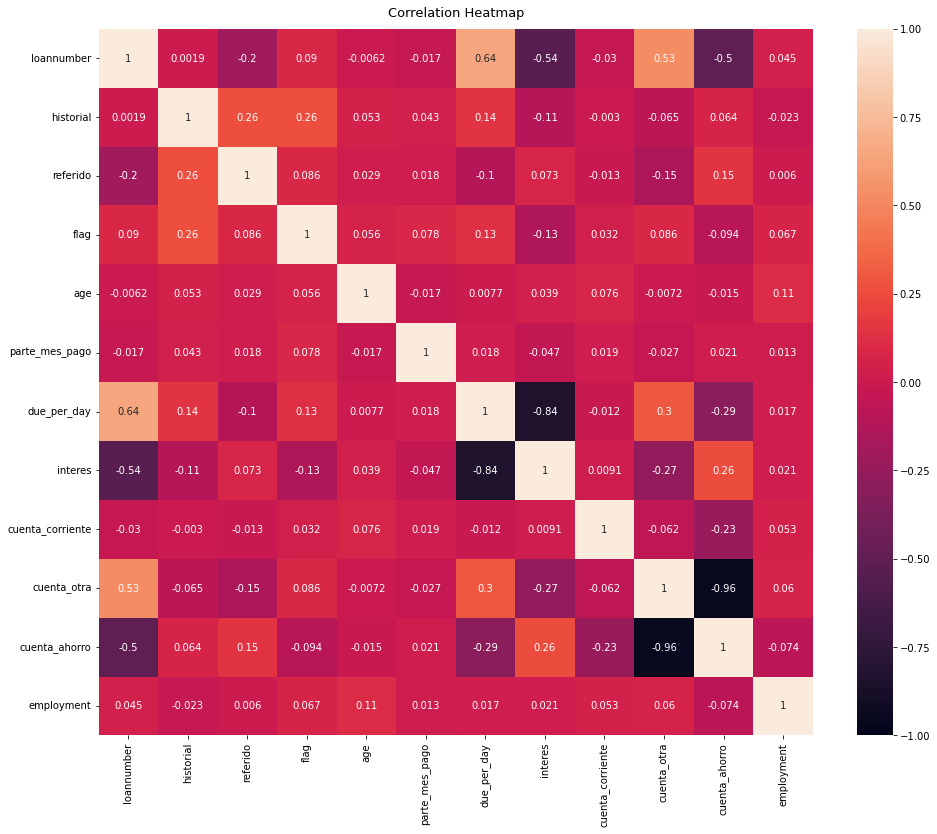

In [113]:
# mostrar un mapa de calor con la correlacion entre variables
plt.figure(figsize=(16, 13))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
hmp = heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':13}, pad=12);
hmp = hmp.get_figure()

## GUARDAR CSV

In [114]:
# df a csv
df_train.to_csv(r'../datasets/own_data/train.csv', index = False)